# Prepare the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

In [2]:
credits = pd.read_csv('dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('dataset/tmdb_5000_movies_nonull.csv')

### Merge two data sets

In [3]:
movies_sub = movies.loc[:, ['id', 'original_title', 'genres']]
credits_sub = credits.loc[:, ['movie_id', 'cast']].rename(columns={'movie_id':'id'})
df = movies_sub.merge(credits_sub)

In [4]:
df.shape

(4799, 4)

In [5]:
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [6]:
# drop movies with no genre info
for i, row in df.iterrows():
    if row['genres'] == '[]':
        df.drop(i, inplace=True)
df = df.dropna()

In [7]:
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


### Briefing of cast and genres

In [8]:
# All cast: # of movies
cast_all = defaultdict(int)

for item in df.cast:
    for p in json.loads(item):
        cast_all[p['name']] += 1

sorted(cast_all.items(), key=lambda x: x[1], reverse=True)[:10]

[('Samuel L. Jackson', 67),
 ('Robert De Niro', 57),
 ('Bruce Willis', 51),
 ('Matt Damon', 48),
 ('Morgan Freeman', 46),
 ('Steve Buscemi', 43),
 ('Liam Neeson', 41),
 ('Johnny Depp', 40),
 ('Owen Wilson', 40),
 ('John Goodman', 39)]

In [9]:
# All genres
all_genres = defaultdict(int)

for row in df.genres:
    for item in json.loads(row):
        all_genres[item['name']] += 1

genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 2296),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894),
 ('Adventure', 790),
 ('Crime', 696),
 ('Science Fiction', 535),
 ('Horror', 519),
 ('Family', 513),
 ('Fantasy', 424),
 ('Mystery', 348),
 ('Animation', 234),
 ('History', 197),
 ('Music', 185),
 ('War', 144),
 ('Documentary', 108),
 ('Western', 82),
 ('Foreign', 34),
 ('TV Movie', 8)]

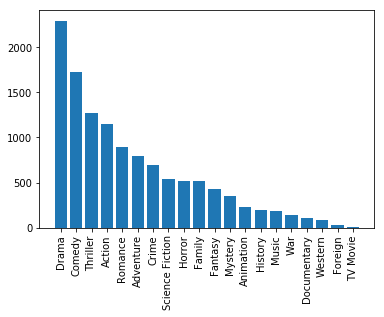

In [10]:
plt.bar(x = [x[0] for x in genres_list], height = [y[1] for y in genres_list])
plt.xticks(rotation=90)
plt.show()

### Modify df

In [11]:
def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1: female += 1
        elif item['gender'] == 2: male += 1
        else: continue
            
    return female, male

In [12]:
def modify_df(cell):
    """Convert string-format json cell to list"""
    my_list = []
    for item in json.loads(cell):
        my_list.append(item['name'])
 
    return my_list

In [13]:
def concat_names(cell):
    """Concatenate first names and last names"""
    names = []
    for name in cell:
        names.append(name.replace(' ', ''))
    return names

In [14]:
# modify df
for col_name in ['genres', 'cast']:
    if col_name == 'cast':
        gen = df[col_name].apply(extract_gender)
        df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]+0.001))
        df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]+0.001))
    
    df[col_name] = df[col_name].apply(modify_df)

In [15]:
# actors/actresses who have only one movie
cast_to_remove = [key for (key, value) in cast_all.items() if value == 1]

In [16]:
# drop cast who have only one movie
for i, row in df.iterrows():
    df.at[i, 'cast'] = list(set(row.cast) - set(cast_to_remove))

In [17]:
# concatenate first and last names
df['cast'] = df['cast'].apply(concat_names)

In [18]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[LukeHawker, JahnelCurfman, JamesGaylyn, Nicol...",0.374988,0.624980
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[LaurenMaher, NaomieHarris, ReggieLee, GilesNe...",0.166661,0.833306
2,206647,Spectre,"[Action, Adventure, Crime]","[LéaSeydoux, NaomieHarris, VictorSchefé, WaiWo...",0.191174,0.808812
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[JayBenedict, HectorAtreyuRuiz, MatthewGooley,...",0.130951,0.869037
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[LynnCollins, PollyWalker, JosephBillingiere, ...",0.239990,0.759970


## Pairwise analysis of Movie Genres


Put highly dependent labels into the same cluster, so that we can assume the four resulting clusters are approximately independent.


*Source: https://spandan-madan.github.io/DeepLearningProject/*

**Four clusters:**  
+ **Exciting**: Thriller, Horror, Action, Adventure, Sci-Fi, Crime, Mystery, Fantasy    
+ **Uplifting**: Drama, Romance, Comedy, Family  
+ **Reality:** Documentary, War, History, Foreign, Music
+ **Others:** Western, TV Movie, Animation

## Change genres to four new subsets

## Cast+gender vs. Genres

In [19]:
for i, row in df.iterrows():
    df.at[i, 'cast'] = ' '.join(row['cast'])

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [21]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, hamming_loss
from sklearn.metrics import roc_auc_score

In [22]:
# One-Hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(df.genres)
train_data, test_data, train_labels, test_labels = train_test_split(df.iloc[:, 3:], mlb.transform(df.genres),
                                                                    test_size=0.2, random_state=42)

In [128]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
train_cast_vect = vectorizer.fit_transform(train_data.iloc[:, 0])
test_cast_vect = vectorizer.transform(test_data.iloc[:, 0])

train_features = np.concatenate((train_cast_vect.toarray(), np.asarray(train_data.iloc[:, 1:])), axis=1)
test_features = np.concatenate((test_cast_vect.toarray(), np.asarray(test_data.iloc[:, 1:])), axis=1)

### Cast+gender (pretty slow)

It's interesting that I only added two columns (female_proportion and male_proportion) to the vectorized cast names, but the running time of fitting a model takes much longer than using only the cast names.  

In [129]:
# gender+cast
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance

# parameters = {'criterion': ['gini', 'entropy']}
# gridCV = GridSearchCV(DecisionTreeClassifier(max_depth=3), parameters,
#                       scoring=make_scorer(accuracy_score), 
#                       cv=10, return_train_score=False)
# clf = OneVsRestClassifier(gridCV)

clf = OneVsRestClassifier(MultinomialNB())

clf.fit(train_features, train_labels)
predicted = clf.predict(test_features)

### Cast only with GridSearchCV

Using cast only takes less time, but the result is slightly worse than using both the cast and the gender proportion, especially the prediction performance of **Action**. No huge difference for other classes.

In [130]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted, target_names=mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.75      0.43      0.54       242
      Adventure       0.76      0.24      0.36       156
      Animation       1.00      0.36      0.53        39
         Comedy       0.77      0.64      0.70       331
          Crime       0.64      0.09      0.15       160
    Documentary       0.00      0.00      0.00        15
          Drama       0.66      0.73      0.69       445
         Family       0.89      0.26      0.40        97
        Fantasy       0.57      0.09      0.15        94
        Foreign       0.00      0.00      0.00         8
        History       0.14      0.03      0.05        34
         Horror       0.89      0.15      0.25       108
          Music       0.50      0.03      0.05        39
        Mystery       0.00      0.00      0.00        84
        Romance       0.53      0.10      0.17       184
Science Fiction       0.53      0.09      0.15       112
       TV Movie       0.00    

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [131]:
accuracy = accuracy_score(y_pred=predicted, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
precision = precision_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
recall = recall_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')

print("Accuracy: {}".format(accuracy)) # subset accuracy
print("F1 score: {}".format(f1))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Accuracy: 0.12670157068062826
F1 score: 0.4633821571238349
Precision: 0.677570093457944
Recall: 0.3520841764467827


In [132]:
for i in range(predicted.shape[1]):
    print('{}: {}'.format(mlb.classes_[i], 
                          accuracy_score(np.asarray(test_labels)[:, i], np.asarray(predicted)[:, i])))

Action: 0.818848167539267
Adventure: 0.86282722513089
Animation: 0.9738219895287958
Comedy: 0.8073298429319372
Crime: 0.8387434554973822
Documentary: 0.9842931937172775
Drama: 0.6973821989528796
Family: 0.9214659685863874
Fantasy: 0.9036649214659686
Foreign: 0.9916230366492147
History: 0.9591623036649215
Horror: 0.9015706806282723
Music: 0.9591623036649215
Mystery: 0.912041884816754
Romance: 0.8094240837696335
Science Fiction: 0.8837696335078534
TV Movie: 1.0
Thriller: 0.7193717277486911
War: 0.9602094240837696
Western: 0.9853403141361257


The high accuracy score for each class is not as meaningful as we expected due to the large number of 0's in the data set, because we care more about recall - whether we can correctly predict that one movie has some genre, instead of correctly predicting that one movie does not have some genre.  
+ Only **Drama**, **Comedy**, and **Action** has relatively good prediction, i.e., high 0-0 proportion, and relatively high 1-1 proportion.  
+ For other classes, although generally we can well predict which classes one movie does not have, but we also fails to get the correct classes in many cases.  

In [133]:
for i in range(predicted.shape[1]):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    
    truth_val = np.asarray(test_labels)[:, i]
    pred_val = np.asarray(predicted)[:, i]
    for vt, vp in zip(truth_val, pred_val):
        if vt==1 and vp==0: fn += 1
        elif vt == 0 and vp==1: fp += 1
        elif vt == 0 and vp==0: tn += 1
        elif vt == 1 and vp==1: tp += 1
    
    print('true1-pred0 rate of {}: {}'.format(mlb.classes_[i], fn/predicted.shape[0]))
    print('true0-pred1 rate of {}: {}'.format(mlb.classes_[i], fp/predicted.shape[0]))
    print('true0-pred0 rate of {}: {}'.format(mlb.classes_[i], tn/predicted.shape[0]))
    print('true1-pred1 rate of {}: {}\n'.format(mlb.classes_[i], tp/predicted.shape[0]))

true1-pred0 rate of Action: 0.14554973821989528
true0-pred1 rate of Action: 0.0356020942408377
true0-pred0 rate of Action: 0.7109947643979058
true1-pred1 rate of Action: 0.10785340314136126

true1-pred0 rate of Adventure: 0.12460732984293194
true0-pred1 rate of Adventure: 0.012565445026178011
true0-pred0 rate of Adventure: 0.8240837696335078
true1-pred1 rate of Adventure: 0.0387434554973822

true1-pred0 rate of Animation: 0.02617801047120419
true0-pred1 rate of Animation: 0.0
true0-pred0 rate of Animation: 0.9591623036649215
true1-pred1 rate of Animation: 0.014659685863874346

true1-pred0 rate of Comedy: 0.12460732984293194
true0-pred1 rate of Comedy: 0.06806282722513089
true0-pred0 rate of Comedy: 0.5853403141361256
true1-pred1 rate of Comedy: 0.22198952879581152

true1-pred0 rate of Crime: 0.15287958115183245
true0-pred1 rate of Crime: 0.008376963350785341
true0-pred0 rate of Crime: 0.8240837696335078
true1-pred1 rate of Crime: 0.014659685863874346

true1-pred0 rate of Documentary: 0

### Next step (after first check-in):
+ Since we are using NB, so prior and conditional prob matters, maybe try other algorithms?
+ adjust prior probabilities?
+ ...

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(mlb.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
mlb.classes_

In [ ]:
# for d in zip(predicted, np.array(test_labels)):
#     print('Predicted:{}, ground truth:{}'.format(d[0], d[1]))